In [1]:
### Change Point Model ###
from change_detection import ChangePointDetector
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt

In [2]:
import sys 
sys.path.append('../../../')
from main import Manager 
m = Manager('../../../')
from bin.plots.volume_oi_chart import price_volume_oi_chart
from bin.utils.tools import pretty_print

2025-05-11 20:46:09,510 - bin.options.optgd.db_connect - INFO - Options DB Initialized
2025-05-11 20:46:09,510 - bin.options.optgd.db_connect - WARNING - You currently have 8 connections open.
2025-05-11 20:46:09,513 - INFO - PriceDB Initialized successfully at 2025-05-11 20:46:09.513288
2025-05-11 20:46:09,513 - bin.price.db_connect - INFO - PriceDB Initialized successfully at 2025-05-11 20:46:09.513288
2025-05-11 20:46:09,513 - INFO - Established 3 database connections
2025-05-11 20:46:09,513 - bin.price.db_connect - INFO - Established 3 database connections
2025-05-11 20:46:09,583 - bin.alerts.options_alerts - INFO - Notifications instance initialized.


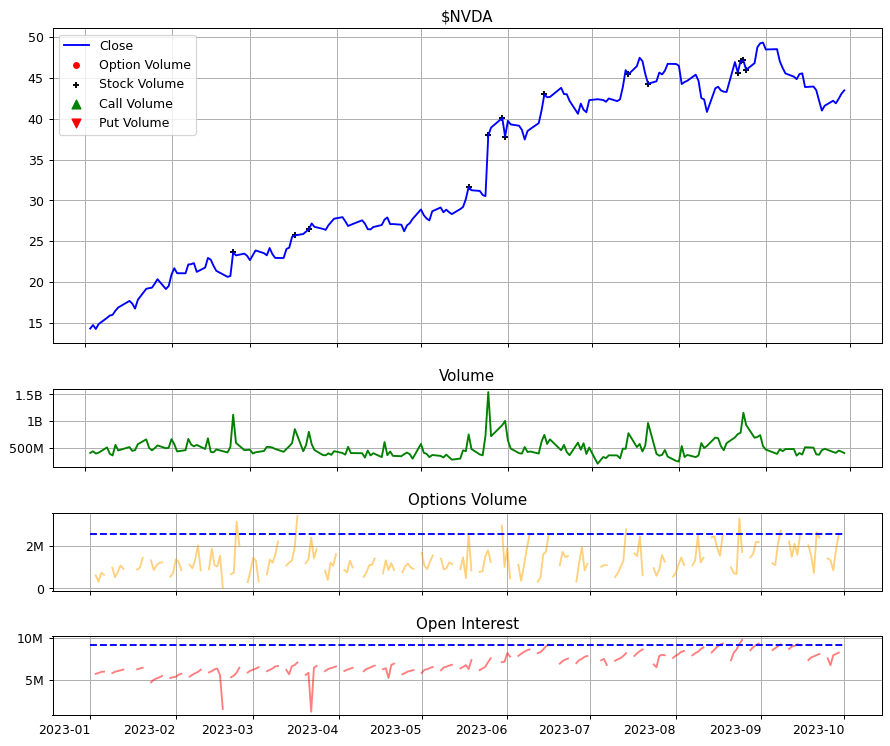

In [3]:
def get_aligned(stock):
    price_df = m.Pricedb.ohlc(stock)
    price_df =price_df.copy().sort_index()
    d = m.Optionsdb.get_daily_option_stats(stock).sort_index()
    d = d.resample('1D').sum()
    price_df = price_df.loc[d.index[0]:]
    d = d.replace(0, np.nan)
    return price_df, d

def show_volume_oi(stock, start_date = None, end_date = None):
    pdf, odf = get_aligned(stock)
    pdf.columns = [x.lower() for x in pdf.columns]
    fig, ax = plt.subplots(4, 1, height_ratios=[2, 0.5, 0.5, 0.5], figsize = (10, 10), dpi = 90)
    price_volume_oi_chart(odf, pdf, fig, ax, stock = stock, start_date=start_date, end_date=end_date)
    fig.show()
    return pdf, odf

_, _ = show_volume_oi('nvda', '2023-01-01', '2023-10-01')

In [4]:
from trend_results import TResults
tr = TResults(
    connections = '../../../',
    lookback_days= 90,
    window_size = 200, 
    period = 30
    
    )


2025-05-11 20:46:10,420 - bin.options.optgd.db_connect - INFO - Options DB Initialized
2025-05-11 20:46:10,420 - bin.options.optgd.db_connect - WARNING - You currently have 8 connections open.
2025-05-11 20:46:10,422 - INFO - PriceDB Initialized successfully at 2025-05-11 20:46:10.422220
2025-05-11 20:46:10,422 - bin.price.db_connect - INFO - PriceDB Initialized successfully at 2025-05-11 20:46:10.422220
2025-05-11 20:46:10,422 - INFO - Established 3 database connections
2025-05-11 20:46:10,422 - bin.price.db_connect - INFO - Established 3 database connections
2025-05-11 20:46:10,452 - bin.alerts.options_alerts - INFO - Notifications instance initialized.


In [5]:
results = tr.analyze_stocks()

Processing nvo: 100%|██████████| 184/184 [00:40<00:00,  4.59it/s, Success=1]


In [6]:
# Convert to DataFrame
data = []
for i in results:
    for result in i:
        data.append({
            'stock': result.stock,
            'metric': result.name,
            'trend_direction': result.trend_direction,
            'seasonality': result.seasonality,
            'slope': result.slope,
            'change_point': result.change_point
        })
df = pd.DataFrame(data)

# Flag slope discrepancies (where trend direction and slope sign don't match)
df['slope_discrepancy'] = ((df['trend_direction'] == 'up') & (df['slope'] < 0)) | ((df['trend_direction'] == 'down') & (df['slope'] > 0))
print("DataFrame with Slope Discrepancies Flagged:")
df[df.slope_discrepancy == True]

DataFrame with Slope Discrepancies Flagged:


,stock,metric,trend_direction,seasonality,slope,change_point,slope_discrepancy
3,gdx,oi,up,normal,-0.000791,0.0,True
5,gdx,call_oi,up,normal,-0.000786,0.0,True
6,gdx,put_oi,up,low,-0.000801,0.0,True
8,gdx,put_volume,up,normal,-0.000682,0.0,True
9,gme,close_prices,up,normal,-0.001417,1.0,True
...,...,...,...,...,...,...,...
1579,pct,atm_iv,up,high,-0.003166,1.0,True
1582,pct,call_volume,down,high,0.089592,1.0,True
1583,pct,put_volume,down,normal,0.084837,1.0,True
1600,tem,call_volume,up,normal,-0.009838,1.0,True


In [7]:
df.metric.unique()

array(['close_prices', 'stock_volume', 'options_volume', 'oi', 'atm_iv',
       'call_oi', 'put_oi', 'call_volume', 'put_volume'], dtype=object)

In [8]:
increasing_oi = df[(df.metric == 'oi') & (df.trend_direction == 'up')].stock.tolist()
increasing_call_oi = df[(df.metric == 'call_oi') & (df.trend_direction == 'up')].stock.tolist()
decreasing_oi = df[(df.metric == 'oi') & (df.trend_direction == 'down')].stock.tolist()

increasing_options_volume = df[(df.metric == 'options_volume') & (df.trend_direction == 'up')].stock.tolist()
increasing_call_volume = df[(df.metric == 'call_volume') & (df.trend_direction == 'up')].stock.tolist()
decreasing_options_volume = df[(df.metric == 'options_volume') & (df.trend_direction == 'down')].stock.tolist()

increasing_price_volume = df[(df.metric == 'price_volume') & (df.trend_direction == 'up')].stock.tolist()
decreasing_price_volume = df[(df.metric == 'price_volume') & (df.trend_direction == 'down')].stock.tolist()

increasing_price = df[(df.metric == 'close_prices') & (df.trend_direction == 'up')].stock.tolist()
decreasing_price = df[(df.metric == 'close_prices') & (df.trend_direction == 'down')].stock.tolist()


def print_10_items_per_line(title, lst):
    print(title)
    print("=====================================")
    for i in range(0, len(lst), 10):
        print(", ".join(lst[i:i+10]))


print_10_items_per_line("Increasing OI:", list(set(increasing_oi + increasing_price)))
print_10_items_per_line("Increasing Call OI:", list(set(increasing_call_oi + increasing_price)))

Increasing OI:
pfe, vxx, fxy, shy, dkng, ntr, f, gdx, abbv, lulu
mrk, wfc, dell, xlb, qcom, mo, xlre, dis, gsl, crwd
enph, mpw, wmt, jpm, cvx, xly, iei, ups, gld, spot
bil, mmm, afrm, run, smh, btu, tbt, dltr, weat, aal
amat, aa, snow, qqq, rtx, uvxy, xle, pct, xrt, rblx
cvs, fang, tsn, bno, gme, mdb, eog, nflx, dbx, lqd
mos, ief, kre, ttd, hd, c, k, v, aig, ge
pgr, icln, xlk, arm, bito, jets, itb, x, clx, aapl
ba, tgt, sony, lmt, xlp, kr, pbw, mu, ko, tmv
amzn, meta, pypl, rkt, u, oxy, hsbc, intu, afl, pltr
sol, sono
Increasing Call OI:
vxx, fxy, shy, ntr, f, gdx, sofi, abbv, ung, wfc
dell, xlb, mo, xlre, dis, crwd, enph, mpw, wmt, jpm
cvx, xly, iei, ups, gld, spot, bil, moo, afrm, run
smh, btu, tbt, dltr, weat, aal, amat, aa, qqq, rtx
uvxy, xle, pct, xrt, rblx, cvs, fang, tsn, bno, gme
mdb, nflx, dbx, mos, ief, kre, c, k, v, aig
ge, pgr, icln, arm, bito, jets, hims, itb, x, clx
aapl, tgt, sony, lmt, xlp, kr, pbw, ko, tmv, meta
pypl, rkt, u, oxy, hsbc, intu, afl, pltr, sol, sono


In [9]:
print_10_items_per_line("Decreasing Options Volume:", decreasing_options_volume)
print_10_items_per_line("Decreasing Price Volume:", decreasing_price_volume)

Decreasing Options Volume:
gdx, gme, amzn, spy, xlf, aapl, pfe, igv, uber, xli
uup, pep, ntr, dkng, mdb, xlu, ups, pltr, vxx, wmt
cvx, fcel, vale, mo, intc, smh, mu, hd, shy, rrc
fdn, lc, vuzi, bkkt, lmt, wfc, crwd, mrk, baba, slv
tsla, sol, mos, qs, msft, tgt, meta, abbv, qqq, ccj
xme, ebay, f, pypl, ibm, xly, amd, amc, xle, xom
xlk, xlv, ibb, clsk, coin, lqd, asan, jets, tlt, xlc
hsbc, kr, afrm, gsl, wba, ung, ba, cmre, intu, snap
nvda, ctva, corn, aa, csco, ko, ctra, snow, li, run
iwm, lulu, oxy, c, abnb, x, mara, clx, jpm, k
tmv, sony, hood, pho, cag, uvxy, bil, ual, pgr, afl
aig, kre, avgo, sofi, mpw, dia, arm, ttd, amat, dash
open, dbx, panw, tdoc, smci, expe, djt, rddt, dell, dltr
adbe, orcl, u, tost, pct, oklo, tem
Decreasing Price Volume:


In [10]:
b = set(increasing_options_volume) & set(increasing_price) & set(increasing_call_volume) & set(increasing_call_oi)
print(b)

{'gld', 'tsn', 'icln', 'fxy', 'tbt', 'ief', 'rblx', 'nflx'}


,total_vol,call_vol_chng,put_vol_chng,total_oi,call_oi_chng,put_oi_chng
date,,,,,,
2025-05-05,"80,022.00","-85,823.00","-46,604.00","5,573,904.00","-169,589.00","-77,592.00"
2025-05-06,"163,741.00","64,130.00","19,589.00","5,627,059.00","25,947.00","27,208.00"
2025-05-07,"336,338.00","19,920.00","-11,064.00","11,355,576.00","74,966.00","26,492.00"
2025-05-08,"457,192.00","15,250.00","-2,108.00","11,414,070.00","41,596.00","16,898.00"
2025-05-09,"520,234.00","-112,529.00","-5,985.00","11,472,218.00","64,468.00","-6,320.00"


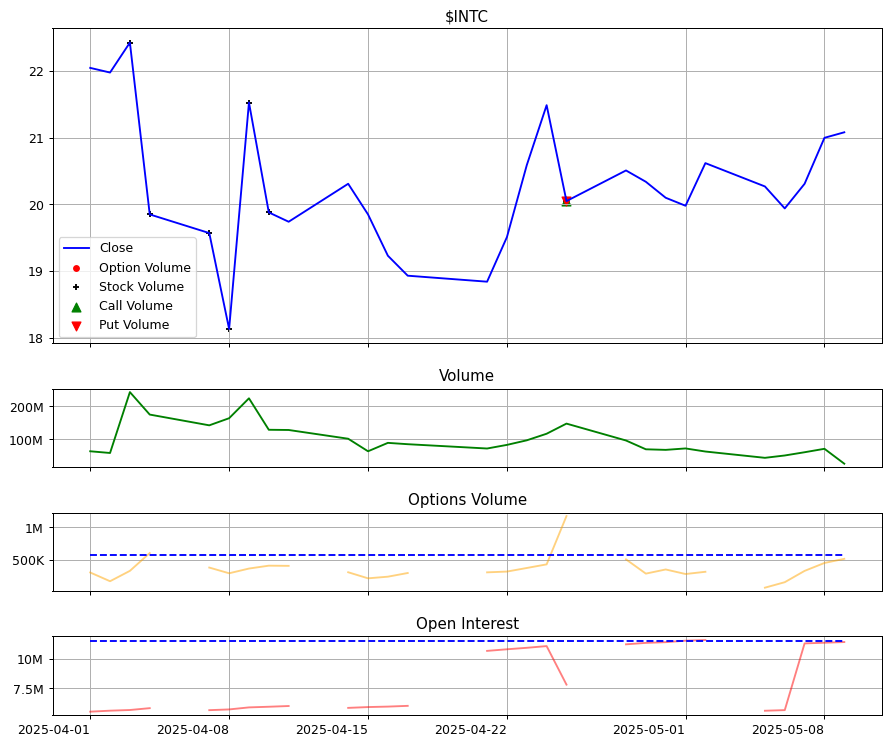

In [18]:
_, odf = show_volume_oi('intc',start_date = "2025-04-01")

pretty_print(odf[['total_vol', 'call_vol_chng', 'put_vol_chng', 'total_oi', 'call_oi_chng', 'put_oi_chng']].tail())

In [ ]:
change_df = df[df.change_point == 1]
call_volume_change = list(change_df[change_df.metric.isin(['call_volume'])].stock.unique())
put_volume_change = list(change_df[change_df.metric.isin(['put_volume'])].stock.unique())
print_10_items_per_line('Call Change Points',call_volume_change)

Call Change Points
gme, spy, xli, goog, dkng, pltr, intc, enph, wfc, tsla
rkt, qqq, iei, ibm, amd, xlb, ibb, coin, afrm, ba
nvda, cvs, run, gld, mara, hood, bil, avgo, ttd, dash
hims, expe, rddt, fxy, dltr, pct, oklo, tem


,total_vol,total_prem,total_oi,call_vol,put_vol,call_oi,put_oi,call_iv,put_iv,atm_iv,...,call_oi_chng,put_oi_chng,call_iv_chng,put_iv_chng,atm_iv_chng,otm_iv_chng,call_vol_pct_chng,put_vol_pct_chng,call_oi_pct_chng,put_oi_pct_chng
date,,,,,,,,,,,,,,,,,,,,,
2025-05-05,18419.0,4.016618e+06,248153.0,11231.0,7188.0,174614.0,73539.0,1.049095,1.084537,1.093129,...,-7406.0,-5219.0,0.080873,0.258446,0.186510,-0.408559,-0.126327,0.126327,0.005666,-0.005666
2025-05-06,41623.0,4.176499e+06,258909.0,29517.0,12106.0,180895.0,78014.0,1.056266,1.085428,1.133813,...,6281.0,4475.0,0.007170,0.000891,0.040684,0.057808,0.099400,-0.099400,-0.004973,0.004973
2025-05-07,141050.0,8.589481e+06,563646.0,102578.0,38472.0,376644.0,187002.0,1.810117,1.723220,1.751724,...,14854.0,30974.0,-0.302415,-0.447636,-0.515903,-0.034968,0.026542,-0.026542,-0.060908,0.060908
2025-05-08,184035.0,9.591246e+06,574616.0,147614.0,36421.0,386854.0,187762.0,1.659448,1.616970,1.670969,...,10210.0,760.0,-0.038326,-0.100360,-0.033990,0.300190,0.148156,-0.148156,0.010022,-0.010022
2025-05-09,87100.0,1.014659e+07,603042.0,61526.0,25574.0,404236.0,198806.0,1.729610,1.334907,1.580321,...,17382.0,11044.0,0.139093,-0.206985,-0.021380,0.486613,-0.168752,0.168752,-0.005822,0.005822


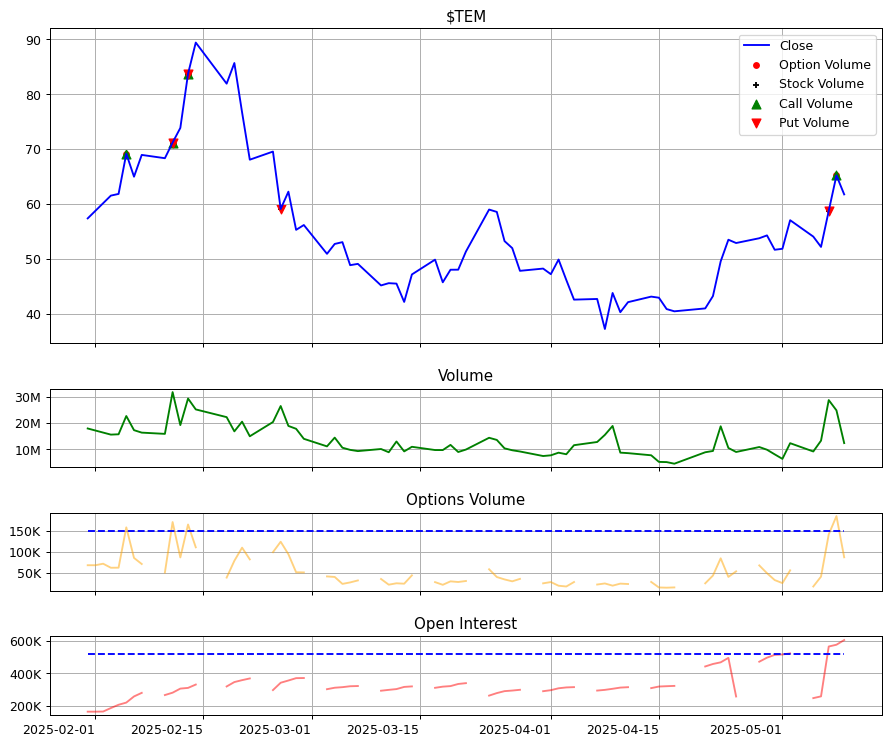

In [13]:
_, b = show_volume_oi('tem')
b.tail()

In [14]:
df

,stock,metric,trend_direction,seasonality,slope,change_point,slope_discrepancy
0,gdx,close_prices,up,high,0.005000,1.0,False
1,gdx,stock_volume,up,low,0.009330,1.0,False
2,gdx,options_volume,down,normal,-0.000911,0.0,False
3,gdx,oi,up,normal,-0.000791,0.0,True
4,gdx,atm_iv,up,low,0.000577,1.0,False
...,...,...,...,...,...,...,...
1606,btu,atm_iv,up,normal,0.054103,1.0,False
1607,btu,call_oi,up,low,0.013180,1.0,False
1608,btu,put_oi,up,normal,0.012314,1.0,False
1609,btu,call_volume,up,high,0.014083,0.0,False
